# PROYECTO II
# *Cryptocurrency Market Data Analytics*

##### Este pryecto consiste en conocer la viabilidad de invertir en criptomonedas en tendencia. Se eligieron monedas que estan basadas en proyectos de IA, servicios de nube y finanzas descentralizadas, ya que son algunos de los temas mas hablados en los ultimos años. 

En este Notebook encontraran todo el trabajo de ETL y EDA necesario para el analisis de los datos 

En el primer paso se importan las librerias que permitirán todas las transformaciones y visualizaciones que se realizarán mas adelante

In [128]:
from pycoingecko import CoinGeckoAPI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime 
import datetime
import time
import matplotlib.dates as plts

Los datos se extraen de la API de **coingecko** y se utiliza la libreria pycoingecko, por lo que se tiene que instanciar un objeto antes de obtener los datos

In [129]:
cg = CoinGeckoAPI() 

In [130]:
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

Se llama la funcion get_coins_list de la API para obtener la lista de las monedas seleccionadas para el analisis 

In [131]:
all_coins_list = cg.get_coins_list()
all_coins_list_df = pd.DataFrame(all_coins_list)
names = ["The Graph","Injective","Render","Ocean Protocol","Fetch.ai","SingularityNET","Akash Network","Oasis Network","OriginTrail","inSure DeFi"]
coins = all_coins_list_df[all_coins_list_df['name'].isin(names)]
coins

,id,symbol,name
302,akash-network,akt,Akash Network
3327,fetch-ai,fet,Fetch.ai
4439,injective-protocol,inj,Injective
4466,insure,sure,inSure DeFi
6307,oasis-network,rose,Oasis Network
6321,ocean-protocol,ocean,Ocean Protocol
6526,origintrail,trac,OriginTrail
7458,render-token,rndr,Render
8001,singularitynet,agix,SingularityNET
8784,the-graph,grt,The Graph


## ETL

Con la funcion get_price obtenemos los precios actuales de todas las monedas, junto con su capitalizacion de mercado y volumen

In [132]:
price_dict = cg.get_price(ids='the-graph,akash-network,fetch-ai,injective-protocol,insure,oasis-network,ocean-protocol,origintrail,render-token,singularitynet',
    vs_currencies='usd',
    include_market_cap = True,
    include_24hr_vol = True)
price_df = pd.DataFrame(price_dict)
price_df 

,akash-network,fetch-ai,injective-protocol,insure,oasis-network,ocean-protocol,origintrail,render-token,singularitynet,the-graph
usd,1.320000e+00,2.131010e-01,7.260000e+00,2.974420e-03,4.025388e-02,3.175980e-01,2.230200e-01,1.480000e+00,1.795340e-01,8.906200e-02
usd_market_cap,2.867115e+08,2.203748e+08,6.063379e+08,8.113003e+07,2.018138e+08,1.376110e+08,8.528624e+07,5.497465e+08,2.202087e+08,8.141836e+08
usd_24h_vol,3.936524e+06,4.432694e+07,2.564413e+07,1.989736e+05,9.704723e+06,3.174005e+07,9.564450e+05,2.137482e+07,3.339541e+07,3.626015e+07


Con la funcion get_coins_markets obtenemos los datos generales de las monedas, este dataset permitirá hacer las comparaciones entre las monedas, por lo que será necesaria algunas transformaciones.

In [133]:

all_coins_market = cg.get_coins_markets(vs_currency ='usd', ids = 'the-graph,akash-network,fetch-ai,injective-protocol,insure,oasis-network,ocean-protocol,origintrail,render-token,singularitynet')
all_coins_market_df = pd.DataFrame(all_coins_market)
all_coins_market_df.head(10) 

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,the-graph,grt,The Graph,https://assets.coingecko.com/coins/images/1339...,0.089062,814183577,46,888457504,36260146,0.092100,...,1.000000e+10,NaN,2.840000,-96.87695,2021-02-12T07:28:45.775Z,0.052051,70.48955,2022-11-22T10:05:03.503Z,None,2023-08-25T18:37:26.173Z
1,injective-protocol,inj,Injective,https://assets.coingecko.com/coins/images/1288...,7.260000,606337917,62,723937549,25644126,7.520000,...,1.000000e+08,1.000000e+08,24.890000,-70.94654,2021-04-30T00:33:02.969Z,0.657401,999.99372,2020-11-03T16:19:30.576Z,None,2023-08-25T18:37:26.324Z
2,render-token,rndr,Render,https://assets.coingecko.com/coins/images/1163...,1.480000,549746456,69,784947771,21374824,1.480000,...,5.310243e+08,5.310243e+08,8.780000,-83.20401,2021-11-21T10:03:19.097Z,0.036657,3924.35033,2020-06-16T13:22:25.900Z,None,2023-08-25T18:37:31.750Z
3,akash-network,akt,Akash Network,https://assets.coingecko.com/coins/images/1278...,1.320000,286711512,117,512391674,3936524,1.440000,...,2.174076e+08,3.885390e+08,8.070000,-83.67393,2021-04-06T18:59:48.484Z,0.164994,699.01427,2022-11-21T20:30:53.727Z,None,2023-08-25T18:37:29.517Z
4,fetch-ai,fet,Fetch.ai,https://assets.coingecko.com/coins/images/5681...,0.213101,220374756,142,243508018,44326939,0.215610,...,1.152998e+09,1.152998e+09,1.170000,-82.04761,2021-09-08T02:24:24.858Z,0.008170,2475.41960,2020-03-13T02:24:18.347Z,"{'times': 1.4579079091054383, 'currency': 'usd...",2023-08-25T18:37:31.545Z
5,singularitynet,agix,SingularityNET,https://assets.coingecko.com/coins/images/2138...,0.179534,220208702,143,357341187,33395409,0.181808,...,1.324917e+09,2.000000e+09,0.950230,-81.22863,2018-01-28T00:00:00.000Z,0.007472,2287.32575,2020-03-13T02:24:16.528Z,"{'times': 0.79534001907104, 'currency': 'usd',...",2023-08-25T18:37:27.727Z
6,oasis-network,rose,Oasis Network,https://assets.coingecko.com/coins/images/1316...,0.040254,201813785,151,401271529,9704723,0.040333,...,1.000000e+10,1.000000e+10,0.597347,-93.28952,2022-01-15T03:31:11.062Z,0.032006,25.24294,2020-11-26T17:09:12.182Z,None,2023-08-25T18:37:28.629Z
7,ocean-protocol,ocean,Ocean Protocol,https://assets.coingecko.com/coins/images/3687...,0.317598,137611025,194,447049650,31740047,0.321440,...,1.410000e+09,1.410000e+09,1.930000,-83.58870,2021-04-10T09:24:58.915Z,0.012848,2365.17005,2019-08-11T00:00:00.000Z,"{'times': 1.6466485157925974, 'currency': 'usd...",2023-08-25T18:37:31.533Z
8,origintrail,trac,OriginTrail,https://assets.coingecko.com/coins/images/1877...,0.223020,85286239,258,111398346,956445,0.223817,...,5.000000e+08,5.000000e+08,3.500000,-93.68628,2021-11-03T18:09:57.627Z,0.003853,5643.94075,2020-03-13T02:24:12.031Z,"{'times': 1.230196007073951, 'currency': 'usd'...",2023-08-25T18:37:20.715Z
9,insure,sure,inSure DeFi,https://assets.coingecko.com/coins/images/1035...,0.002974,81130032,270,269781628,198974,0.003257,...,8.800000e+10,8.800000e+10,0.113970,-97.32229,2021-01-06T21:22:32.766Z,0.000156,1855.51612,2021-06-28T04:52:56.935Z,None,2023-08-25T18:37:34.215Z


Se utiliza el metodo info() para conocer la cantidad de nulos y los tipos de datos

In [134]:
all_coins_market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                10 non-null     object 
 1   symbol                            10 non-null     object 
 2   name                              10 non-null     object 
 3   image                             10 non-null     object 
 4   current_price                     10 non-null     float64
 5   market_cap                        10 non-null     int64  
 6   market_cap_rank                   10 non-null     int64  
 7   fully_diluted_valuation           10 non-null     int64  
 8   total_volume                      10 non-null     int64  
 9   high_24h                          10 non-null     float64
 10  low_24h                           10 non-null     float64
 11  price_change_24h                  10 non-null     float64
 12  price_chang

In [135]:
all_coins_market_df.columns


Index(['id', 'symbol', 'name', 'image', 'current_price', 'market_cap',
       'market_cap_rank', 'fully_diluted_valuation', 'total_volume',
       'high_24h', 'low_24h', 'price_change_24h',
       'price_change_percentage_24h', 'market_cap_change_24h',
       'market_cap_change_percentage_24h', 'circulating_supply',
       'total_supply', 'max_supply', 'ath', 'ath_change_percentage',
       'ath_date', 'atl', 'atl_change_percentage', 'atl_date', 'roi',
       'last_updated'],
      dtype='object')

In [136]:
all_coins_market_df.shape

(10, 26)

Se observa si hay datos nulos. En este caso, la columna "roi" es la columna con mas datos nulos y se descartara. Max_supply tambien tiene un dato nulo, se debe a que una de las monedas no tiene en su proyecto limite de circulacion.

In [137]:
all_coins_market_df.isna().sum()

id                                  0
symbol                              0
name                                0
image                               0
current_price                       0
market_cap                          0
market_cap_rank                     0
fully_diluted_valuation             0
total_volume                        0
high_24h                            0
low_24h                             0
price_change_24h                    0
price_change_percentage_24h         0
market_cap_change_24h               0
market_cap_change_percentage_24h    0
circulating_supply                  0
total_supply                        0
max_supply                          1
ath                                 0
ath_change_percentage               0
ath_date                            0
atl                                 0
atl_change_percentage               0
atl_date                            0
roi                                 6
last_updated                        0
dtype: int64

Se crea una nueva columna para conocer el porcentaje de criptomonedas que han sido liberadas. En este caso, se divide las monedas que están en circulacion entre el maximo  que puede crear la criptomoneda.

In [138]:
all_coins_market_df["monedas_circulantes"] = all_coins_market_df['circulating_supply'] / all_coins_market_df['max_supply']

Se crea una nueva columna para conocer el porcertaje de las monedas que no han sido liberadas

In [139]:
all_coins_market_df["monedas_faltantes"] = 1 - all_coins_market_df["monedas_circulantes"]

Se eliminan las columnas que no se utilizaran 

In [140]:
all_coins_market_df = all_coins_market_df.drop(["image"	,"high_24h"	,"low_24h",	"price_change_24h" , "price_change_percentage_24h" ,"market_cap_change_24h"	,"market_cap_change_percentage_24h",	"ath",	"ath_change_percentage","ath_date",	"fully_diluted_valuation",	"circulating_supply"	,"total_supply"	,"max_supply"	,"atl" ,"atl_change_percentage",	"atl_date"	,"roi"	,"last_updated"	], axis=1)

In [141]:
all_coins_market_df.head()

,id,symbol,name,current_price,market_cap,market_cap_rank,total_volume,monedas_circulantes,monedas_faltantes
0,the-graph,grt,The Graph,0.089062,814183577,46,36260146,NaN,NaN
1,injective-protocol,inj,Injective,7.260000,606337917,62,25644126,0.837556,0.162444
2,render-token,rndr,Render,1.480000,549746456,69,21374824,0.700361,0.299639
3,akash-network,akt,Akash Network,1.320000,286711512,117,3936524,0.559555,0.440445
4,fetch-ai,fet,Fetch.ai,0.213101,220374756,142,44326939,0.905000,0.095000


## EDA

#### Comparación entre monedas en circulación 

En el siguiente grafico se observa la comparación del porcentaje de monedas que han sido liberadas y que aún no han sido liberadas. Hay que mencionar que la moneda “The Graph” no posee un “máximo de circulación” por lo que no se puede comparar en el gráfico. 

Se observa que las monedas OriniginTrail, Fetch.ai e Injective tienen mas del 70% de monedas en circulación, mientras que Oasis Network, SingularityNet, Akash Network y Render tienen mas del 40% en circulación, por ultimo InSure DeFi y Ocean Protocol tienen menos del 40% en circulación. 


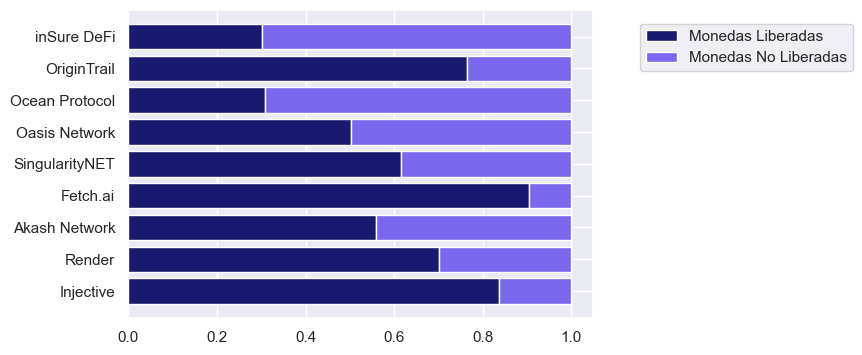

In [142]:
y = 10
names = all_coins_market_df["name"]
m_circulante = all_coins_market_df["monedas_circulantes"]
m_faltante = all_coins_market_df["monedas_faltantes"]

fig, ax = plt.subplots(figsize=(6,4))
h = 0.6
ax.barh( names, m_circulante, label ="Monedas Liberadas", color = "#191970")
ax.barh(names, m_faltante, left = m_circulante, label = "Monedas No Liberadas", color = "#7B68EE")
ax.legend(loc = (1.1, 0.8))

#### Comparación entre capitalización de mercado

La capitalización de mercado es el valor total de las monedas en circulación. Dependiendo el contexto, puede indicar el nivel de volatilidad y el dominio que tiene la moneda en el mercado.

Con el siguiente grafico se compara la capitalización de mercado entre las monedas. Se puede observar que la moneda The Graph, posicionada entre las 100 criptomonedas actualmente en el mercado, tiene la capitalización más grande. Sin embargo, esta moneda no tiene “máximo de circulación”, quiere decir que se trata de una moneda inflacionaria. 
El resto de las monedas tienen máximo de circulación, en este sentido, su capitalización de mercado puede indicar que monedas tienen más posibilidades de subir de precio en un futuro. 


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12576\2715022576.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(all_coins_market_df['name']))


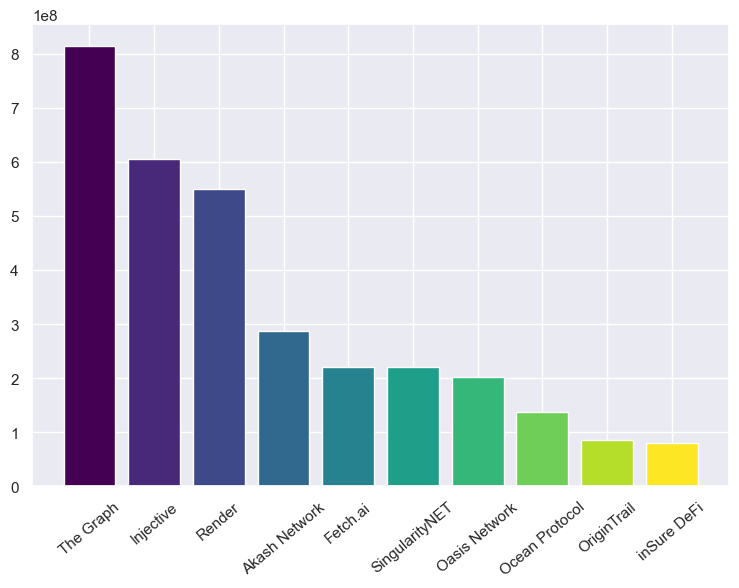

In [143]:
colors = plt.cm.get_cmap('viridis', len(all_coins_market_df['name']))
plt.figure(figsize=(9,6))
plt.bar(x=all_coins_market_df['name'], height=all_coins_market_df['market_cap'], color=colors(np.arange(len(all_coins_market_df['name']))))
plt.xticks(rotation=40)
plt.show()

En el siguiente grafico se compara el precio entre las monedas

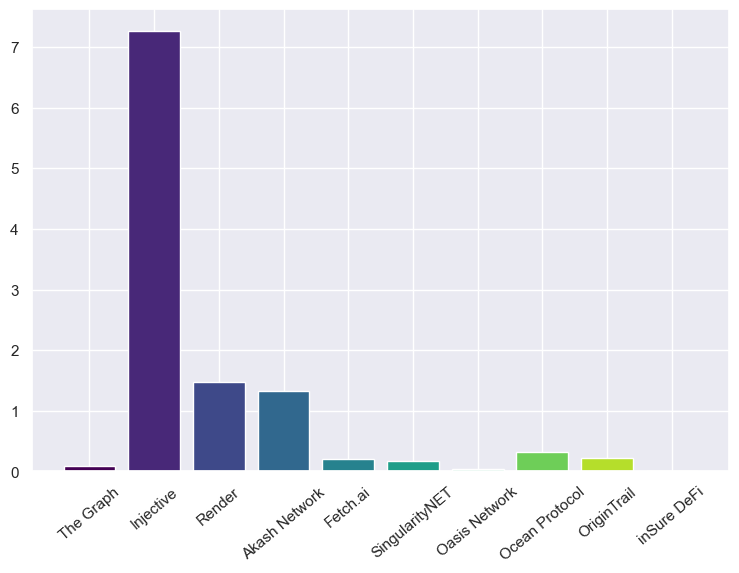

In [144]:
plt.figure(figsize=(9,6))
plt.bar(x=all_coins_market_df['name'], height=all_coins_market_df['current_price'], color=colors(np.arange(len(all_coins_market_df['name']))))
plt.xticks(rotation=40)
plt.show()

#### Comparación entre la relación Capitalización-Precio

Los siguientes dos gráficos tiene como propósito realizar una comparación entre la relación precio & capitalización. 

Como se había mencionado anteriormente, se puede observar que la moneda The Graph aunque tiene una capitalización alta su precio es bajo porque se trata de una moneda inflacionaria. Monedas como Insure DeFi y Oasis Network, aunque tienen precios muy bajos su capitalización no es tan alta, por lo que puede haber posibilidad de crecimiento. 

Por otro lado, la moneda Injective tiene buena capitalización, y una circulación de más del 80% de monedas liberadas, lo que lleva a tener un buen precio en comparación a las otras monedas. 


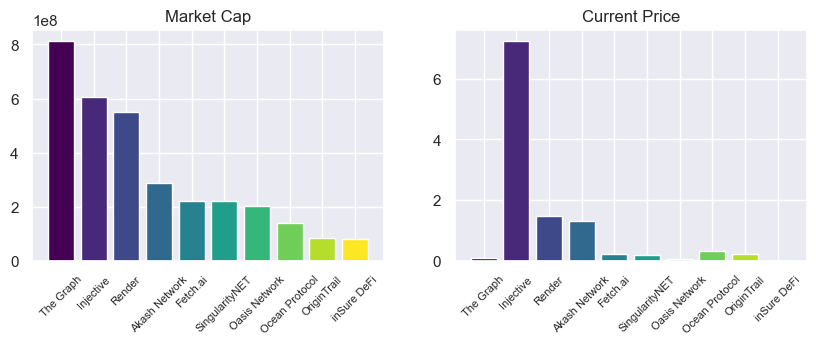

In [145]:

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].bar(x=all_coins_market_df['name'], height=all_coins_market_df['market_cap'], color=colors(np.arange(len(all_coins_market_df['name']))))
axs[0].set_title('Market Cap')
axs[0].tick_params(axis='x', labelsize=8, rotation=45)

axs[1].bar(x=all_coins_market_df['name'], height=all_coins_market_df['current_price'], color=colors(np.arange(len(all_coins_market_df['name']))))
axs[1].set_title('Current Price')
axs[1].tick_params(axis='x', labelsize=8, rotation=45)

plt.show()

La API coingecko trabaja con marca de tiempo unix por lo que es necesario crear una funcion donde covierta una fecha comun en tiempo unix para luego obtener los datos historicos

In [146]:

def unix_time(year,month,day,second):
    date_time = datetime.datetime(year,month,day,second)
    return time.mktime(date_time.timetuple())

Las monedas seleccionadas son relativamente nuevas en el mercado, por lo que su participacion se destacan a partir del año 2020. Se tomará esta fecha de inicio para extraer los datos historicos.

In [147]:
star = unix_time(2020,1,1,0)
end = unix_time(2023,8,1,0)
print(star)
print(end)

1577851200.0
1690862400.0


Para obtener los datos historicos se llama la funcion get_coin_market_chart_range_by_id. Tal funcion solo permite un id, por esta razon se llama la funcion por cada una de las monedas. 

In [148]:
coin_history_render = cg.get_coin_market_chart_range_by_id(id ='render-token',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0', 
    localization = False)
coin_history_df_render = pd.DataFrame(coin_history_render)
coin_history_df_render.head()

,prices,market_caps,total_volumes
0,"[1592179200000, 0.05118805501524312]","[1592179200000, 0.0]","[1592179200000, 22018.40134820023]"
1,"[1592265600000, 0.05118805501524312]","[1592265600000, 0.0]","[1592265600000, 22018.40134820023]"
2,"[1592352000000, 0.06108038461684783]","[1592352000000, 0.0]","[1592352000000, 29909.198788969163]"
3,"[1592438400000, 0.09554858553854906]","[1592438400000, 0.0]","[1592438400000, 74787.31123602368]"
4,"[1592524800000, 0.07527105237214486]","[1592524800000, 0.0]","[1592524800000, 36559.29931279299]"


Si observamos un ejemplo del dataframe obtenido por la funcion get_coin_market_chart_range_by_id, este devuelve el tiempo unix por cada precio, capitalizacion y volumen. Por lo que será necesario extraer ese tiempo y colocarlo en una nueva columna.

In [149]:
coin_history_df_render["time"] = [x[0] for x in coin_history_render["prices"]]

In [150]:
coin_history_df_render.head()

,prices,market_caps,total_volumes,time
0,"[1592179200000, 0.05118805501524312]","[1592179200000, 0.0]","[1592179200000, 22018.40134820023]",1592179200000
1,"[1592265600000, 0.05118805501524312]","[1592265600000, 0.0]","[1592265600000, 22018.40134820023]",1592265600000
2,"[1592352000000, 0.06108038461684783]","[1592352000000, 0.0]","[1592352000000, 29909.198788969163]",1592352000000
3,"[1592438400000, 0.09554858553854906]","[1592438400000, 0.0]","[1592438400000, 74787.31123602368]",1592438400000
4,"[1592524800000, 0.07527105237214486]","[1592524800000, 0.0]","[1592524800000, 36559.29931279299]",1592524800000


Luego se crea una funcion que convierte el tiempo unix en fecha y se aplica a la columna time. Con el propósito de que el grafico que muestra los datos historicos tenga fechas legibles

In [151]:
def normal_time(unix_time):
    unix_time = unix_time / 1000
    resultado = datetime.datetime.fromtimestamp(unix_time)
    return resultado
normal_time(1662008531400)

datetime.datetime(2022, 9, 1, 1, 2, 11, 400000)

In [152]:

coin_history_df_render["time"] = coin_history_df_render["time"].apply(normal_time)

Luego se deja solo los datos necesarios por columna, eliminando las fechas en cada una de las columnas.

In [153]:
coin_history_df_render["total_volumes"] = [x[1] for x in coin_history_df_render["total_volumes"]]
coin_history_df_render["prices"] = [x[1] for x in coin_history_df_render["prices"]]
coin_history_df_render["market_caps"] = [x[1] for x in coin_history_df_render["market_caps"]]

In [154]:
coin_history_df_render.head()

,prices,market_caps,total_volumes,time
0,0.051188,0.0,22018.401348,2020-06-14 20:00:00
1,0.051188,0.0,22018.401348,2020-06-15 20:00:00
2,0.061080,0.0,29909.198789,2020-06-16 20:00:00
3,0.095549,0.0,74787.311236,2020-06-17 20:00:00
4,0.075271,0.0,36559.299313,2020-06-18 20:00:00


Se se hace el mismo procedimiento con cada una de las monedas seleccionadas

In [155]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='the-graph',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0', 
    to_timestamp = '1690862400.0', 
    localization = False)
coin_history_df_graph = pd.DataFrame(coin_history)
coin_history_df_graph["time"] = [x[0] for x in coin_history_df_graph["prices"]]
coin_history_df_graph["time"] = coin_history_df_graph["time"].apply(normal_time)
coin_history_df_graph["total_volumes"] = [x[1] for x in coin_history_df_graph["total_volumes"]]
coin_history_df_graph["prices"] = [x[1] for x in coin_history_df_graph["prices"]]
coin_history_df_graph["market_caps"] = [x[1] for x in coin_history_df_graph["market_caps"]]

In [156]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='injective-protocol',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_injective = pd.DataFrame(coin_history)
coin_history_df_injective["time"] = [x[0] for x in coin_history_df_injective["prices"]]
coin_history_df_injective["time"] = coin_history_df_injective["time"].apply(normal_time)
coin_history_df_injective["total_volumes"] = [x[1] for x in coin_history_df_injective["total_volumes"]]
coin_history_df_injective["prices"] = [x[1] for x in coin_history_df_injective["prices"]]
coin_history_df_injective["market_caps"] = [x[1] for x in coin_history_df_injective["market_caps"]]

In [157]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='akash-network',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_akash = pd.DataFrame(coin_history)
coin_history_df_akash["time"] = [x[0] for x in coin_history_df_akash["prices"]]
coin_history_df_akash["time"] = coin_history_df_akash["time"].apply(normal_time)
coin_history_df_akash["total_volumes"] = [x[1] for x in coin_history_df_akash["total_volumes"]]
coin_history_df_akash["prices"] = [x[1] for x in coin_history_df_akash["prices"]]
coin_history_df_akash["market_caps"] = [x[1] for x in coin_history_df_akash["market_caps"]]

In [158]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='fetch-ai',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_fetch = pd.DataFrame(coin_history)
coin_history_df_fetch["time"] = [x[0] for x in coin_history_df_fetch["prices"]]
coin_history_df_fetch["time"] = coin_history_df_fetch["time"].apply(normal_time)
coin_history_df_fetch["total_volumes"] = [x[1] for x in coin_history_df_fetch["total_volumes"]]
coin_history_df_fetch["prices"] = [x[1] for x in coin_history_df_fetch["prices"]]
coin_history_df_fetch["market_caps"] = [x[1] for x in coin_history_df_fetch["market_caps"]]

In [159]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='insure',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_insure = pd.DataFrame(coin_history)
coin_history_df_insure["time"] = [x[0] for x in coin_history_df_insure["prices"]]
coin_history_df_insure["time"] = coin_history_df_insure["time"].apply(normal_time)
coin_history_df_insure["total_volumes"] = [x[1] for x in coin_history_df_insure["total_volumes"]]
coin_history_df_insure["prices"] = [x[1] for x in coin_history_df_insure["prices"]]
coin_history_df_insure["market_caps"] = [x[1] for x in coin_history_df_insure["market_caps"]]

In [160]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='oasis-network',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_oasis = pd.DataFrame(coin_history)
coin_history_df_oasis["time"] = [x[0] for x in coin_history_df_oasis["prices"]]
coin_history_df_oasis["time"] = coin_history_df_oasis["time"].apply(normal_time)
coin_history_df_oasis["total_volumes"] = [x[1] for x in coin_history_df_oasis["total_volumes"]]
coin_history_df_oasis["prices"] = [x[1] for x in coin_history_df_oasis["prices"]]
coin_history_df_oasis["market_caps"] = [x[1] for x in coin_history_df_oasis["market_caps"]]

In [161]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='ocean-protocol',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_ocean = pd.DataFrame(coin_history)
coin_history_df_ocean["time"] = [x[0] for x in coin_history_df_ocean["prices"]]
coin_history_df_ocean["time"] = coin_history_df_ocean["time"].apply(normal_time)
coin_history_df_ocean["total_volumes"] = [x[1] for x in coin_history_df_ocean["total_volumes"]]
coin_history_df_ocean["prices"] = [x[1] for x in coin_history_df_ocean["prices"]]
coin_history_df_ocean["market_caps"] = [x[1] for x in coin_history_df_ocean["market_caps"]]

In [162]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='origintrail',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_origin = pd.DataFrame(coin_history)
coin_history_df_origin["time"] = [x[0] for x in coin_history_df_origin["prices"]]
coin_history_df_origin["time"] = coin_history_df_origin["time"].apply(normal_time)
coin_history_df_origin["total_volumes"] = [x[1] for x in coin_history_df_origin["total_volumes"]]
coin_history_df_origin["prices"] = [x[1] for x in coin_history_df_origin["prices"]]
coin_history_df_origin["market_caps"] = [x[1] for x in coin_history_df_origin["market_caps"]]

In [163]:
coin_history = cg.get_coin_market_chart_range_by_id(id ='singularitynet',
    vs_currency = 'usd' ,
    from_timestamp = '1577851200.0',
    to_timestamp = '1690862400.0',
    localization = False)
coin_history_df_singulairy = pd.DataFrame(coin_history)
coin_history_df_singulairy["time"] = [x[0] for x in coin_history_df_singulairy["prices"]]
coin_history_df_singulairy["time"] = coin_history_df_singulairy["time"].apply(normal_time)
coin_history_df_singulairy["total_volumes"] = [x[1] for x in coin_history_df_singulairy["total_volumes"]]
coin_history_df_singulairy["prices"] = [x[1] for x in coin_history_df_singulairy["prices"]]
coin_history_df_singulairy["market_caps"] = [x[1] for x in coin_history_df_singulairy["market_caps"]]

Se renombran los dataframe solo para hacerlos mas simples

In [164]:
render = coin_history_df_render
the_graph = coin_history_df_graph
singularity = coin_history_df_singulairy
akash = coin_history_df_akash
ocean = coin_history_df_ocean
oasis = coin_history_df_oasis
injective = coin_history_df_injective
insure = coin_history_df_insure
fetch = coin_history_df_fetch
origin = coin_history_df_origin

Se crea el siguiente grafico que muestra la capitalizacion de mercado por moneda. En este caso se observa:
- ninguna ha sufrido "rug pull"
- se presenta volatilidad en todas las monedas

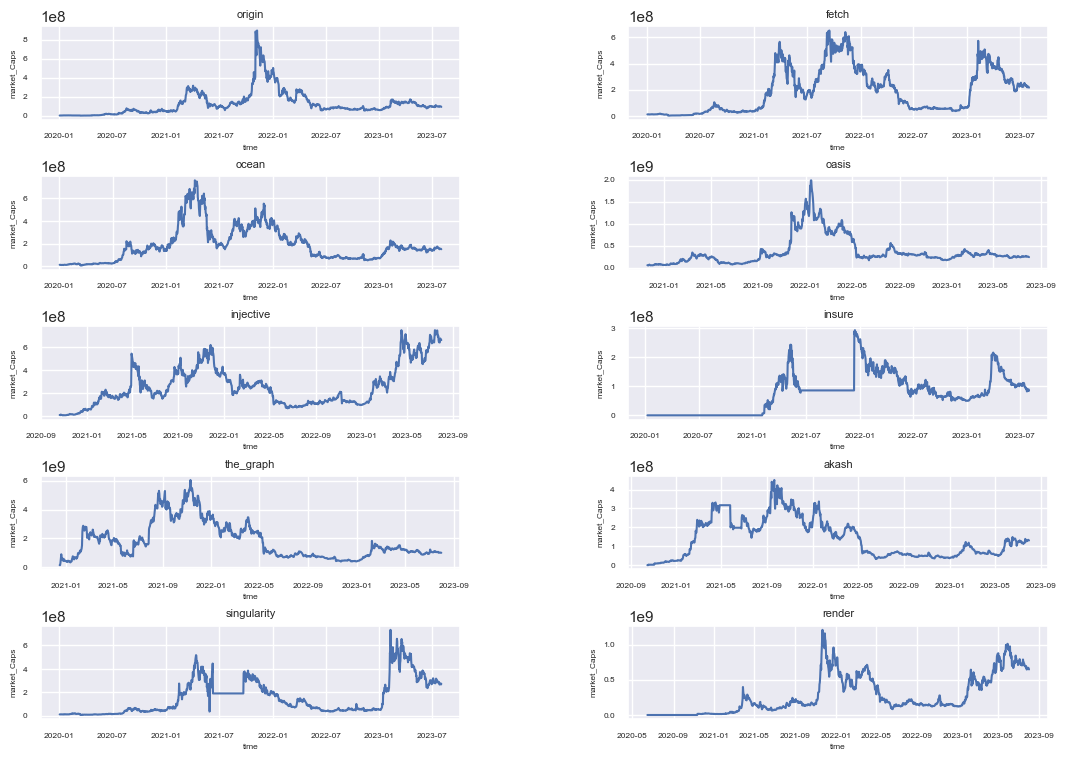

In [165]:
diccionarios = [origin, fetch, ocean, oasis, injective, insure, the_graph, akash, singularity, render]

num_filas = (len(diccionarios) + 1) // 2
num_columnas = 2

fig, axs = plt.subplots(num_filas, num_columnas)

for i in range(len(diccionarios)):

    fila = i // 2
    columna = i % 2

    market_caps = diccionarios[i]["market_caps"]
    time = diccionarios[i]["time"]
    nombres = ["origin", "fetch", "ocean", "oasis", "injective", "insure", "the_graph", "akash", "singularity", "render"]
    
    axs[fila][columna].plot(time, market_caps)
    
    
    axs[fila][columna].set_title(nombres[i], fontsize=8)
    axs[fila][columna].set_xlabel("time", fontsize=6)
    axs[fila][columna].set_ylabel("market_Caps", fontsize=6)
    
  
    axs[fila][columna].tick_params(axis='x', labelsize=6)
    axs[fila][columna].tick_params(axis='y', labelsize=6)


plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

### ¿Por qué comparar volumen y precio?
-	Los próximos gráficos muestran la relación volumen & precio por cada moneda desde el año 2021 hasta el 2023. El volumen muestra la suma de transacciones realizadas en un periodo y su relación con el precio puede indicar cuando existe demanda, confianza o debilidad en el mercado. 


#### 1)	Render
En este grafico se observa que el volumen y el precio van en la misma dirección, lo que significa que el mercado tiene confianza. Su máximo histórico se realizó a principios del 2022 y este año su volumen ha aumentado con un precio relativamente estable. En este caso, el volumen está indicando una tendencia alcista.


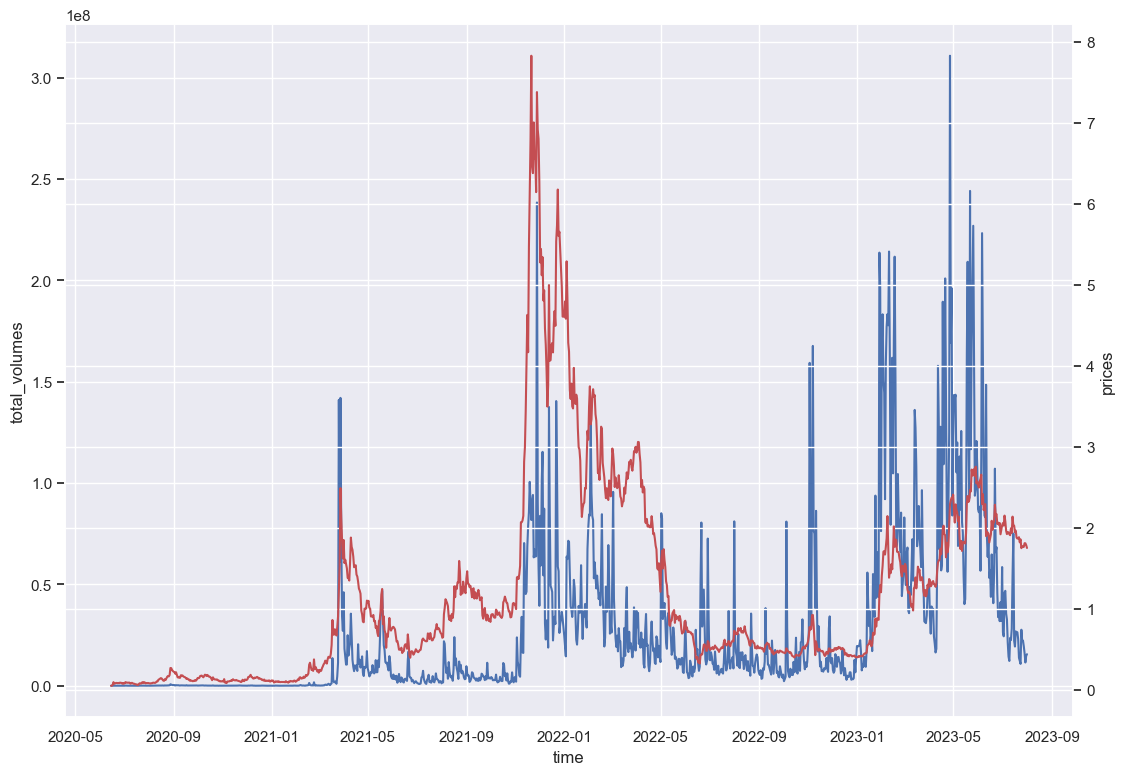

In [181]:

sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= render)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=render, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()


#### 2)	Injective

En este grafico se observa  que durante el año 2021 no había muchos compradores, pues el volumen se encuentra por debajo del precio. A comienzos del 2022 el volumen se dispara y el precio disminuye lo que quiere decir que la oferta supera la demanda por lo que la tendencia fue bajista. En el año 2023 el precio sube moderadamente junto con el volumen, aunque no se trata de una tendencia alcista, quiere decir que la moneda puede continuar en crecimiento. 


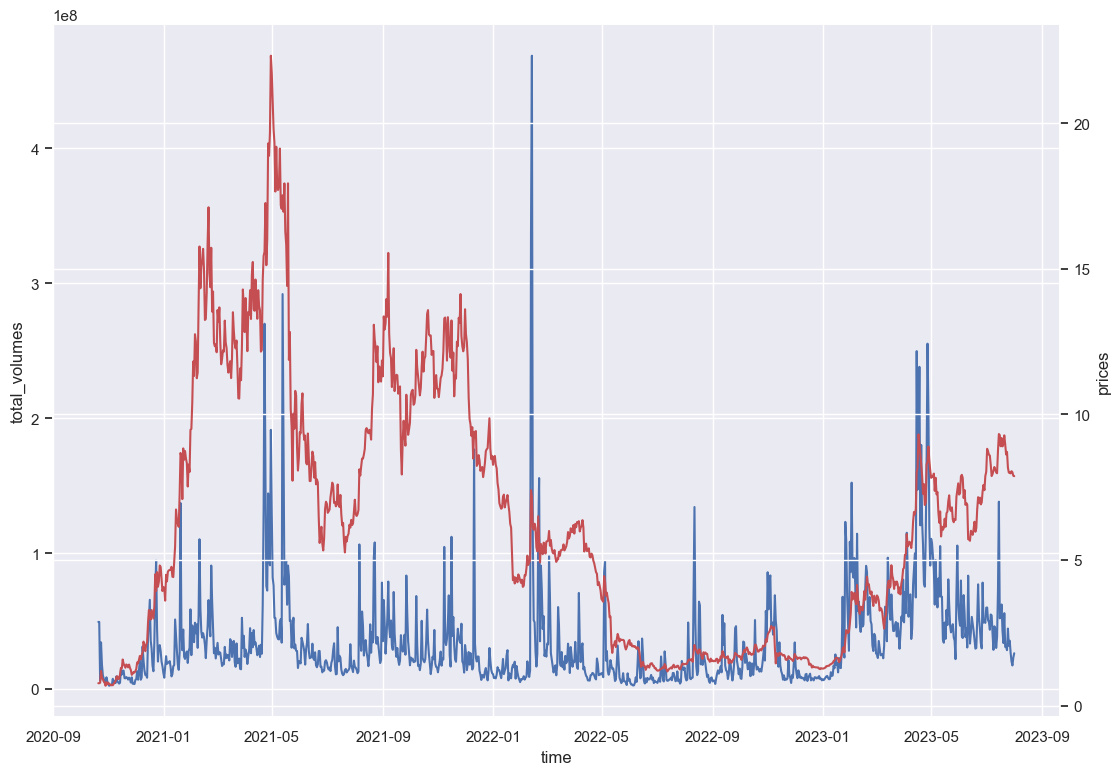

In [167]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= injective)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=injective, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 3)	The Graph 
A principios del 2021 el volumen aumento junto con su máximo histórico, pero se observa que el precio fue disminuyendo al tener poco volumen. Esto indica que desde mediados del 2021 hay pocos compradores, es decir, la tendencia es débil. 


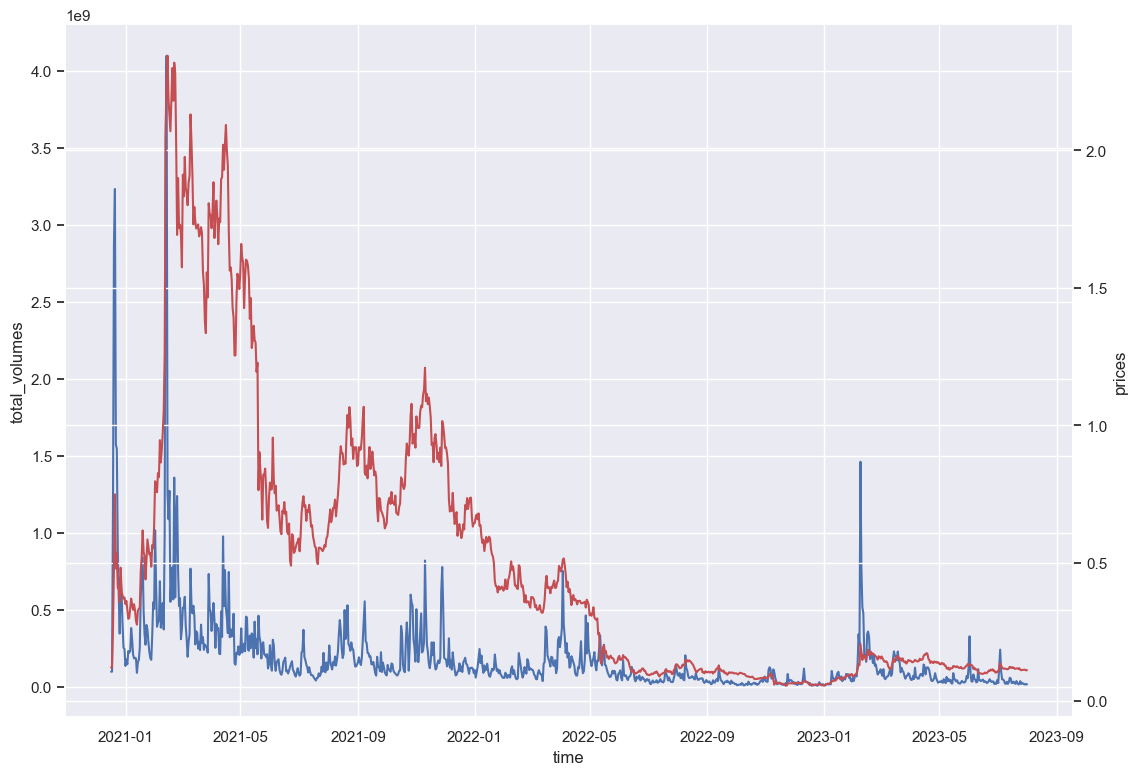

In [168]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= the_graph)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=the_graph, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 4)	Singularity
Desde el 2021 hasta comienzos de 2023 se observa poca participación. A principios del 2023 se  muestra que el volumen y el precio van en la misma dirección lo que quiere decir que el mercado puede crecer en los próximos meses. 


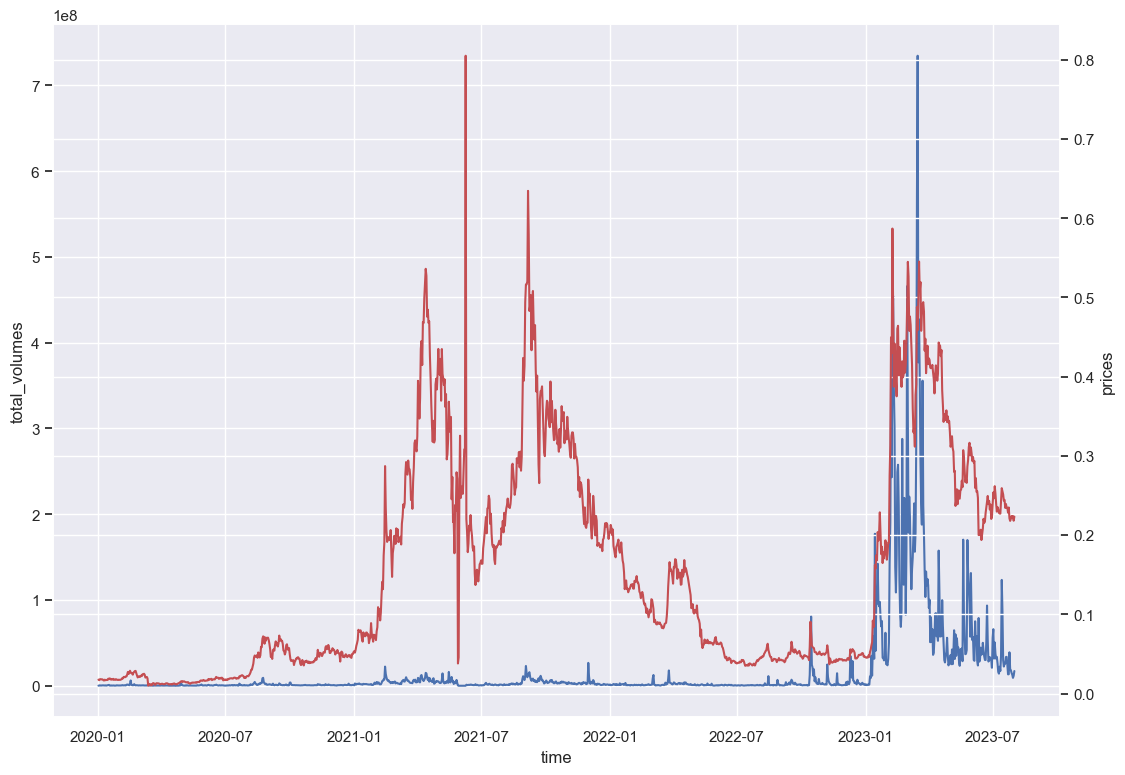

In [169]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= singularity)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=singularity, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 5)	Akash
Se observa que desde el año 2021 hasta mediados del 2022 el volumen y el precio se manejaban en la misma dirección, sin embargo luego el precio se mantiene por debajo del volumen, lo que quiere decir que hay compradores que cada vez están dispuestos a aceptar menos por la moneda. La tendencia es bajista.


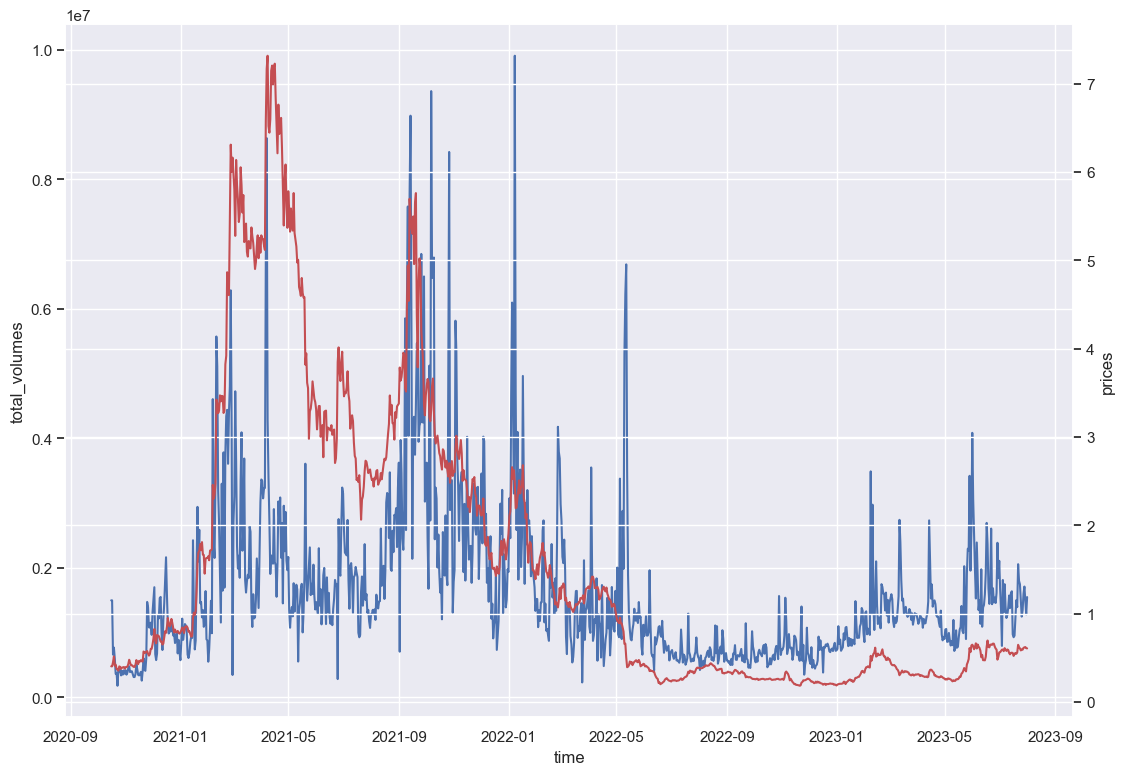

In [170]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= akash)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=akash, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 6)	Origin
En este grafico se observa que la participación ha sido baja en todas las temporadas, esto quiere decir que existe una tendencia débil.


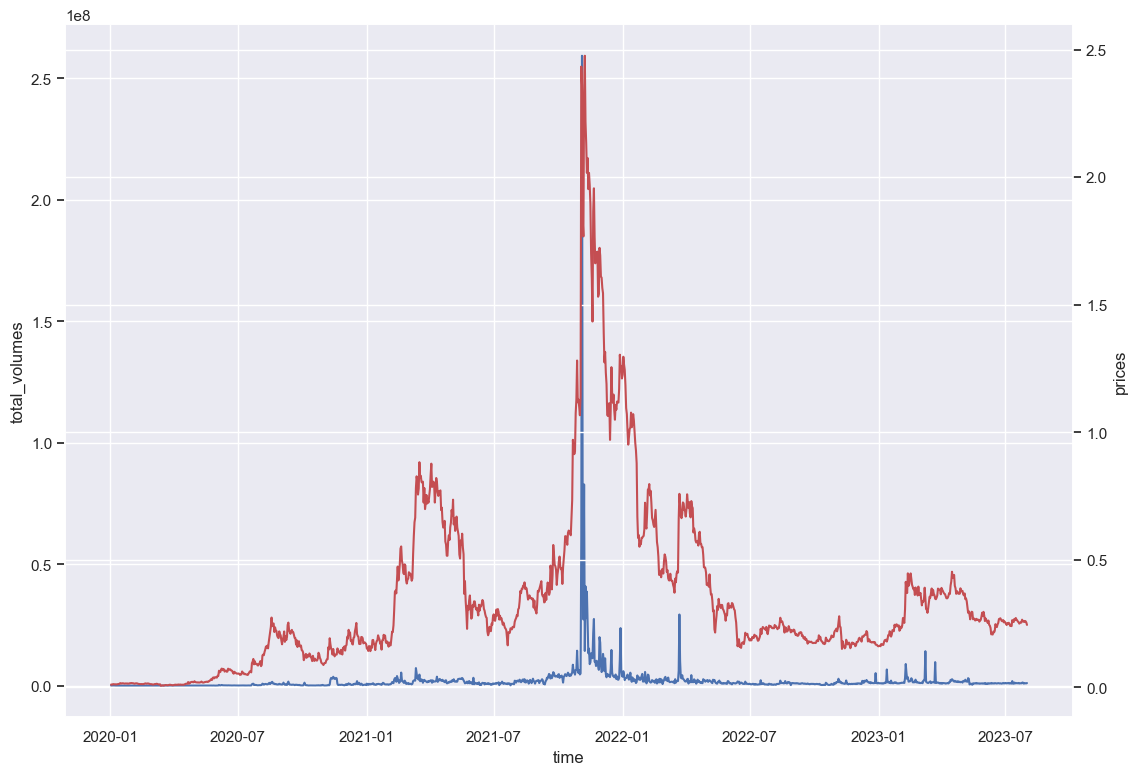

In [171]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= origin)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=origin, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 7)	Ocean 
En este caso se observa que el año con mayor participación fue el 2021, aunque el precio siempre está por encima del volumen, ambos se dirigen en la misma dirección, lo que quiere decir que existen posibilidades de que la moneda continúe en crecimiento. 


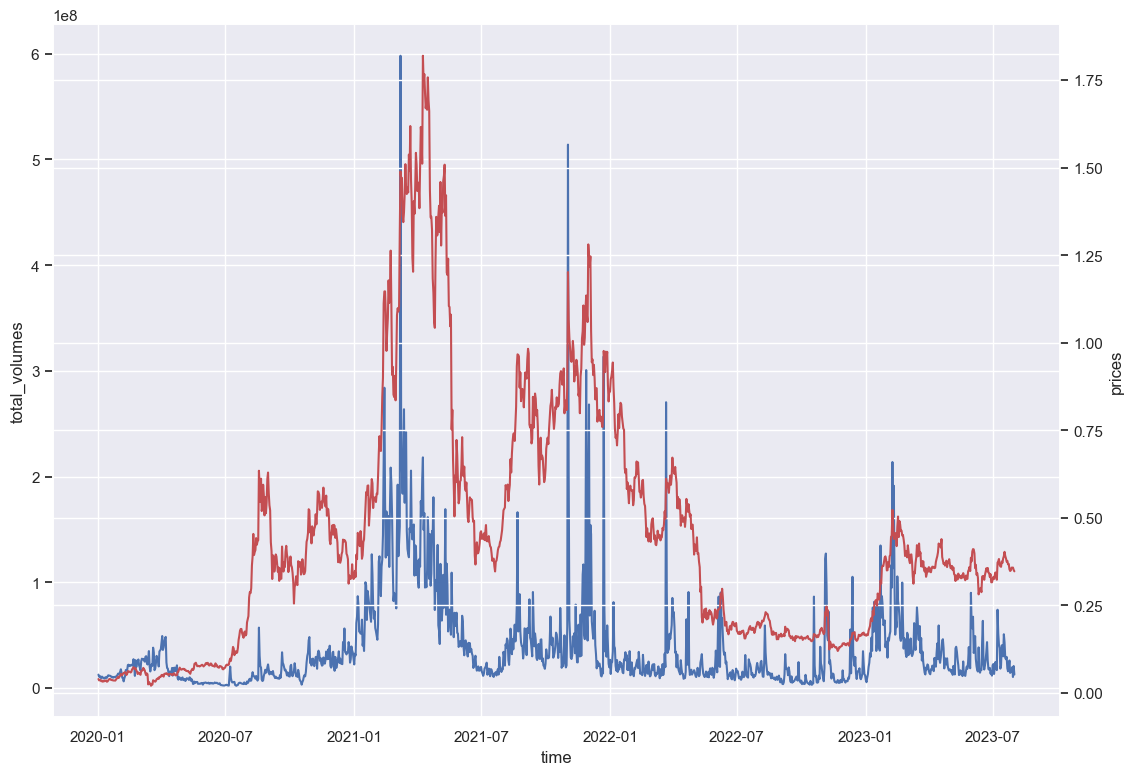

In [172]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= ocean)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=ocean, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 8)	Oasis
Se observa que el volumen y el precio están en la misma dirección (aunque el año 2023 el precio no ha aumentado y se ha mantenido) el volumen indica que exite una tendencia alcista por lo que la moneda puede seguir en crecimiento. 


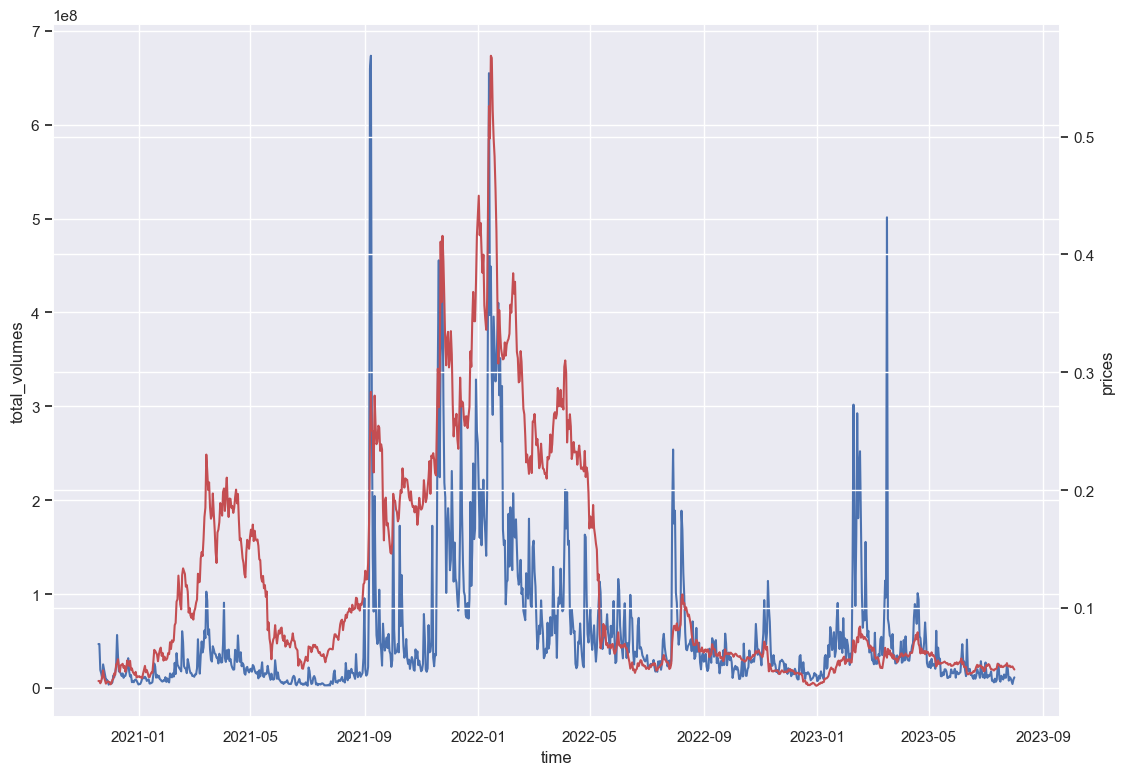

In [173]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= oasis)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=oasis, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 9)	Fetch
Se observa que el precio siempre está por encima del volumen pero la participación sigue siendo significante. En el año 2023 el volumen subió junto con el precio, esto quiere decir que la tendencia es alcista y el mercado puede seguir en crecimiento. 


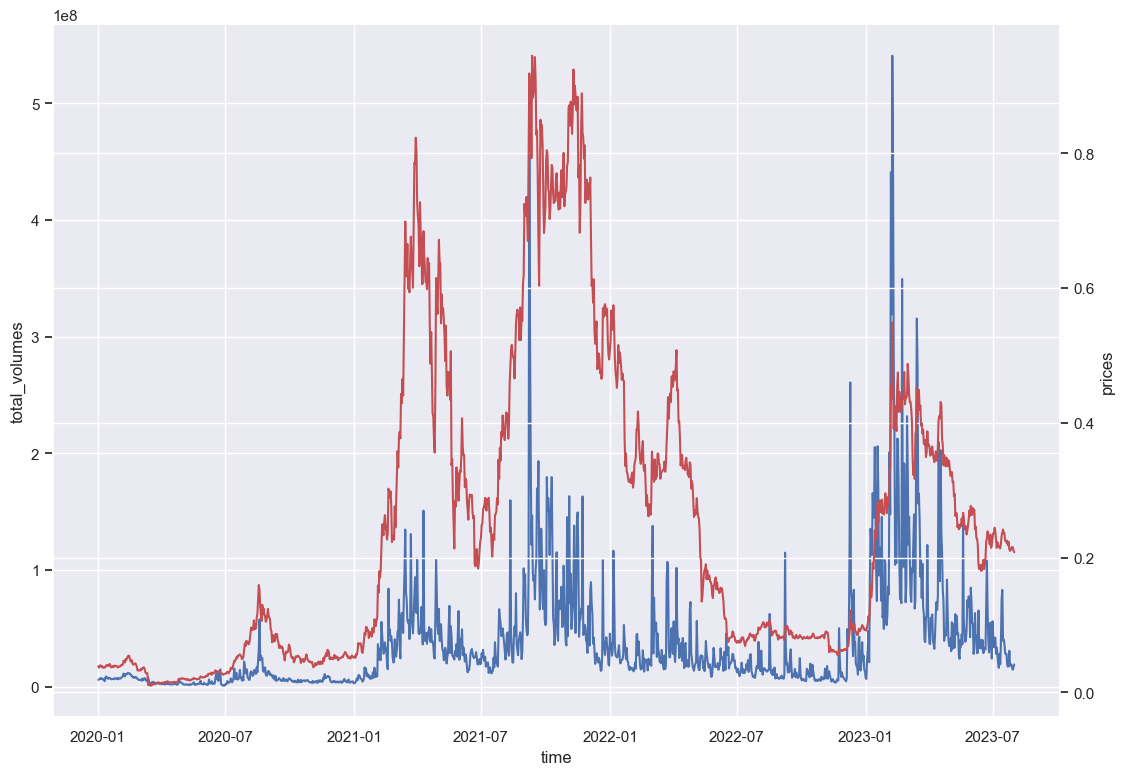

In [174]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= fetch)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=fetch, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()

#### 10)	Insure
En este grafico se observa que a mediados del año 2021 subió la participación pero con un precio bajo que se ha mantenido desde entonces, sin embargo, el volumen tampoco ha disminuido lo que puede significar que  la moneda puede crecer en las próximas temporadas.


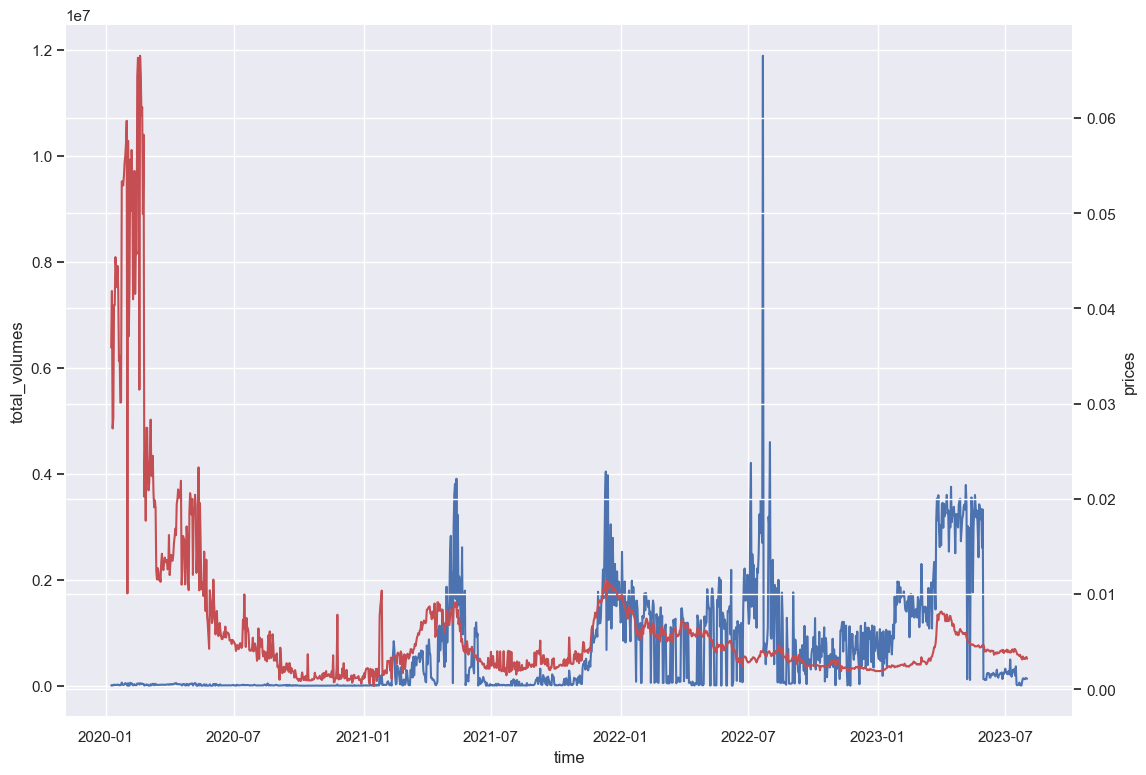

In [175]:
sns.set(rc={"figure.figsize":(13,9)})
sns.set_theme(style="darkgrid")
sns.lineplot(x="time", y= "total_volumes", data= insure)

ax2 = plt.twinx()

sns.lineplot( x="time", y="prices", data=insure, ax=ax2, color = "r")

plt.xticks(rotation=45)
plt.show()